# Iron Condor

### Benefits of Extra Long Put in Iron Condor 

- Downside Protection: The extra long puts can act as a form of insurance by providing additional protection against significant downward moves in the underlying asset. This helps limit potential losses in case the market moves sharply against the trader's position.

- Increased Volatility Concerns: If the trader anticipates a higher-than-expected increase in market volatility, the extra long puts can help mitigate the impact of such volatility on the overall position.

- Dynamic Position Adjustments: Traders might use extra long puts as part of a dynamic adjustment strategy. If the market conditions change, such as increased volatility or a shift in the trend, the additional long puts can be used to modify the risk profile of the Iron Condor.

- Protection Against Tail Events: Extra long puts can offer protection against rare but severe market events (tail risk). While the probability of such events is low, having protection in place can be crucial for risk-averse traders.

- Reducing Margin Requirements: In some cases, adding extra long puts might allow for a reduction in overall margin requirements. This could be relevant for traders who are constrained by margin limitations and want to optimize their capital usage.

- Shift in Market Sentiment: If there's a change in the trader's sentiment or outlook for the underlying asset, adding extra long puts may align the strategy with a more bearish view, providing a hedge against unexpected downside moves.

## Step 0 : Importing all Libraries 

In [27]:
import yfinance as yf                 # For downloading Data
import matplotlib.pyplot as plt       # For Plotting Data
import numpy as np                    # For numerical Calculations
import pandas as pd                   # For working with DataFrames and Data Processig
import datetime                       # For Datetime Manipulations
import seaborn as sns                 # For Plotting the Graphs 
import opstrat as op                  # For Option Strategy Analysis
from scipy.stats import norm


## Step 1 : Data Collection and Data Processing 

In [28]:
# Using Apple for Option analyis 
ticker=yf.Ticker('AAPL')                # Store yfinance ticker object
expirations_dates_list=ticker.options   # List of all expirations for given ticker symbol 


##### **Very Important Cell  - Spot Price will be used till last Option Class Building and Analysis**

In [29]:
aapl=yf.download(tickers='AAPL')        # Downloading stock Data from yfiance
spot_price=aapl['Close'][-1]            # Storing Recent Apple Stock Price as spot price. To be used in Analysis  ### Very Very Important Cell
price=aapl.loc['2024-02-05']['Close']   # Storing Apple Stock Close Price for a Particular Date 
print(f'Spot Price of Apple Stock is {np.round(spot_price,3)}')


[*********************100%%**********************]  1 of 1 completed

Spot Price of Apple Stock is 186.92


###  1.1  :  Data Storage in Data DataFrames/Dictionaries for different Analysis

In [30]:
option = pd.DataFrame()                                     # Data frame to contain all data of option chain for different expiry in a vertical stacked format     
option_call_put_volume = pd.DataFrame()                     # Dataframe containing both call put option volume data for different expiry  
option_implied_volatility_call = pd.DataFrame()             # Dataframe containing implied volatilities for call option
option_implied_volatility_put = pd.DataFrame()              # Dataframe containing implied volatilities for put option
option_call_put_OI=pd.DataFrame()                           # Dataframe containing call and put option OI data 
option_chain_data={}                                        # Dictionary of all option chains with expiry date used keys

for expiry_date in expirations_dates_list:                  # Using loops for storing option chain data 
    opt = ticker.option_chain(expiry_date)
    option_call_data = opt.calls.copy()
    option_put_data = opt.puts.copy()
    option_data = pd.concat([option_call_data, option_put_data])

    option_data['expirationDate'] = expiry_date
    option = pd.concat([option, option_data], ignore_index=True)

    # Option Chain Compilation
    # Renaming option chain dataframe columns
    renamed_columns=['contract Call', 'lastTradeDate_x', 'strike', 'Price Call', 'bid_x',
       'ask_x', 'Price Change Call', 'Price %Change Call', 'Call Volume', 'Call OI',
       'Call IV', 'inTheMoney_x', 'contractSize_x', 'currency_x',
       'contract Put', 'lastTradeDate_y', 'Price Put', 'bid_y', 'ask_y',
       'Price Change Put', 'Price %Change Put', 'Put Volume', 'Put OI',
       'Put IV', 'inTheMoney_y', 'contractSize_y', 'currency_y']
    # Merging option chain data based on strike price to build option chain. This is stored in dictionary   
    option_chain_data[expiry_date]=pd.merge(left=option_call_data,right=option_put_data,on='strike')
    option_chain_data[expiry_date].columns=renamed_columns

    #Drop columns not required in the analysis
    option_chain_data[expiry_date].drop(['lastTradeDate_x','bid_x',
       'ask_x', 'inTheMoney_x', 'contractSize_x', 'currency_x', 
       'lastTradeDate_y','bid_y', 'ask_y','inTheMoney_y', 'contractSize_y', 'currency_y'],axis=1,inplace=True)
    
    # ReIndexing Columns of Option Chain DataFrame
    option_chain_data[expiry_date] = option_chain_data[expiry_date].reindex(columns=['contract Call',  'Price Call', 'Price Change Call',
       'Price %Change Call', 'Call Volume', 'Call OI', 'Call IV',
       'strike', 'Price Put', 'Price Change Put', 'Price %Change Put',
       'Put Volume', 'Put OI', 'Put IV','contract Put'])


   #  Option Volume Data Compilation
    option_volume = option_call_data[['strike', 'volume']] + option_put_data[['strike', 'volume']]
    option_volume['expirationDate'] = expiry_date
    option_call_put_volume = pd.concat([option_call_put_volume, option_volume], ignore_index=True)

    # Option Implied Volatility Compilation
    option_IV_call = option_call_data[['strike', 'impliedVolatility']].copy()
    option_IV_call['expirationDate'] = expiry_date
    option_implied_volatility_call = pd.concat([option_implied_volatility_call, option_IV_call])

    option_IV_put = option_put_data[['strike', 'impliedVolatility']].copy()
    option_IV_put['expirationDate'] = expiry_date
    option_implied_volatility_put = pd.concat([option_implied_volatility_put, option_IV_put])

    # OI data Compilation
    option_OI = option_call_data[['strike', 'openInterest']] + option_put_data[['strike', 'openInterest']]
    option_OI['expirationDate'] = expiry_date
    option_call_put_OI = pd.concat([option_call_put_OI, option_OI], ignore_index=True)




#### Implied Volatilities for Different Expiries for Call Option Contracts



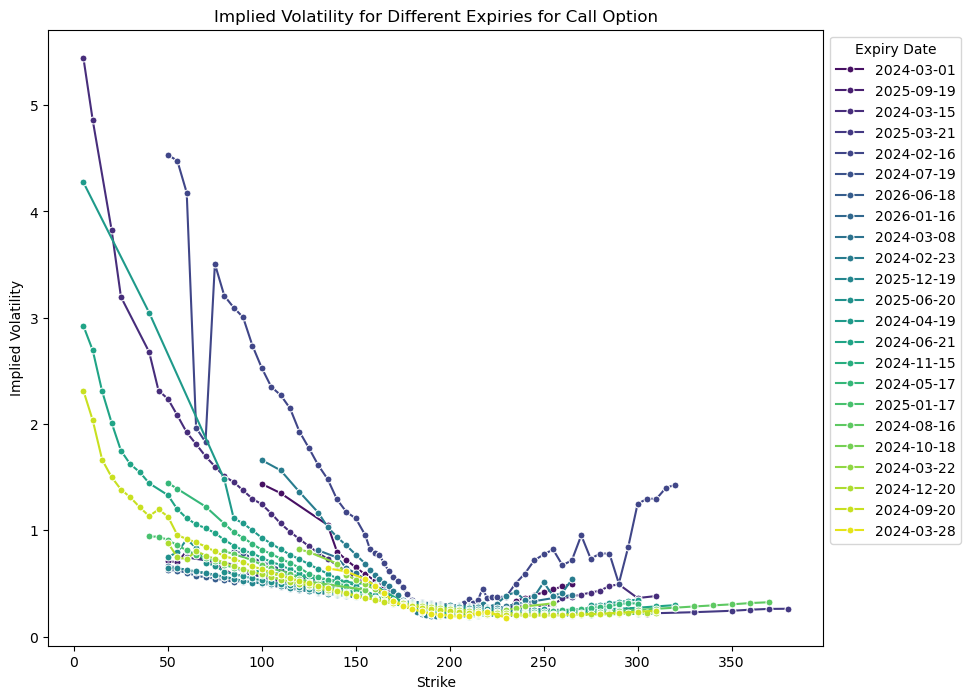

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a color palette for better distinguishability
palette = sns.color_palette('viridis', n_colors=len(set(option_implied_volatility_call['expirationDate'])))

plt.figure(figsize=(10, 8))

for i, expiry_date in enumerate(set(option_implied_volatility_call['expirationDate'])):
    df = option_implied_volatility_call[option_implied_volatility_call['expirationDate'] == expiry_date].copy()
    
    # Smooth out the curves using a rolling mean
    df['smoothed_IV'] = df['impliedVolatility'].rolling(window=2, min_periods=1).mean()
    
    # Plot the smoothed curve with markers and the specified color from the palette
    sns.lineplot(data=df, x='strike', y='smoothed_IV', label=expiry_date, color=palette[i], marker='o', markersize=5)

plt.title('Implied Volatility for Different Expiries for Call Option')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



- In this plot we will see how the IV for different Call option  with the different expiries vary witht the strike price. We can see that the latest expiry has the hightest IV curve followed by upcoming expiries.
- Near ITM has lowest IV whereas OTM and DOTM has high IVs

#### Implied Volatilities for Different Expiries for Put Option Contracts

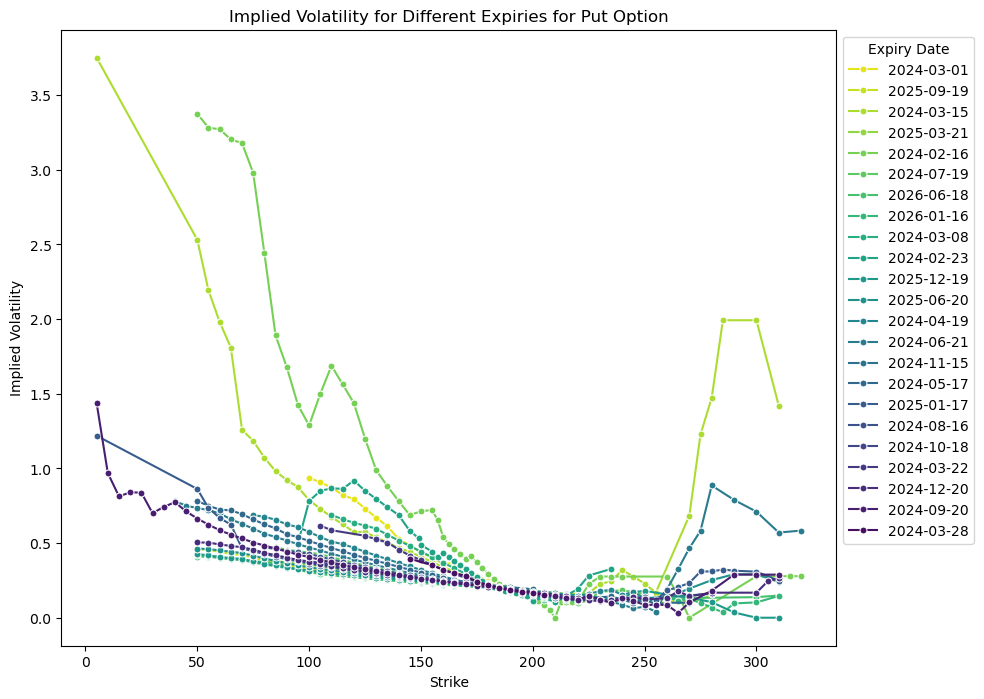

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_put = sns.color_palette('viridis', n_colors=len(set(option_implied_volatility_put['expirationDate'])))
reversed_palette_put = list(reversed(palette_put))

plt.figure(figsize=(10, 8))

for i, expiry_date in enumerate(set(option_implied_volatility_put['expirationDate'])):
    df_put = option_implied_volatility_put[option_implied_volatility_put['expirationDate'] == expiry_date].copy()
    
    # Smooth out the curves using a rolling mean
    df_put['smoothed_IV'] = df_put['impliedVolatility'].rolling(window=5, min_periods=1).mean()
    
    # Plot the smoothed curve with markers and the specified color from the reversed palette
    sns.lineplot(data=df_put, x='strike', y='smoothed_IV', label=expiry_date, color=reversed_palette_put[i], marker='o', markersize=5)

plt.title('Implied Volatility for Different Expiries for Put Option')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


- In this plot we will see how the IV for different Put option  with the different expiries vary witht the strike price. We can see that the latest expiry has the hightest IV curve followed by upcoming expiries.
- Near ITM has lowest IV whereas OTM and DOTM has high IVs.
- We can see that on the right side, the curve has higher IV than call counterpart and forms the Smile Structure. These curves are not symmteric as assumed in the Black Scholes model. 

#### Plotting Total Volume for Call Put Option Contracts for Different Expiries

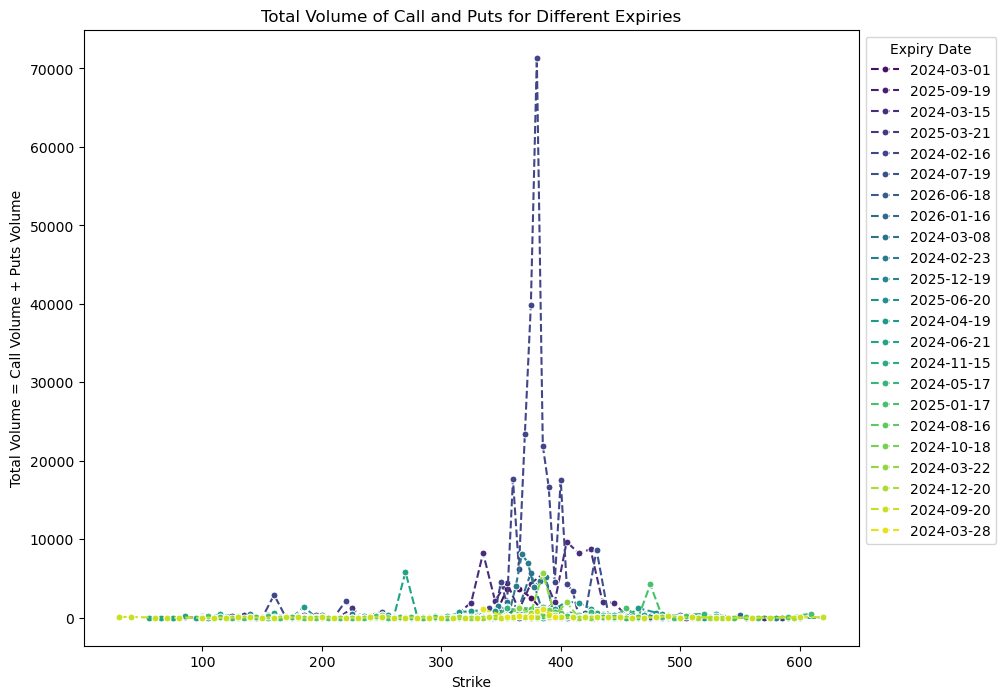

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_volume = sns.color_palette('viridis', n_colors=len(set(option_call_put_volume['expirationDate'])))

plt.figure(figsize=(10, 8))

for i, expiry_date in enumerate(set(option_call_put_volume['expirationDate'])):
    df_volume = option_call_put_volume[option_call_put_volume['expirationDate'] == expiry_date].copy()
    
    # Plot histogram with markers and different line styles
    sns.lineplot(data=df_volume, x='strike', y='volume', label=expiry_date, 
                 color=palette_volume[i], marker='o', linestyle='--', markersize=5)

plt.title('Total Volume of Call and Puts for Different Expiries')
plt.xlabel('Strike')
plt.ylabel('Total Volume = Call Volume + Puts Volume')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


#### Plotting Open Interest Call Put Option for Different Expiries

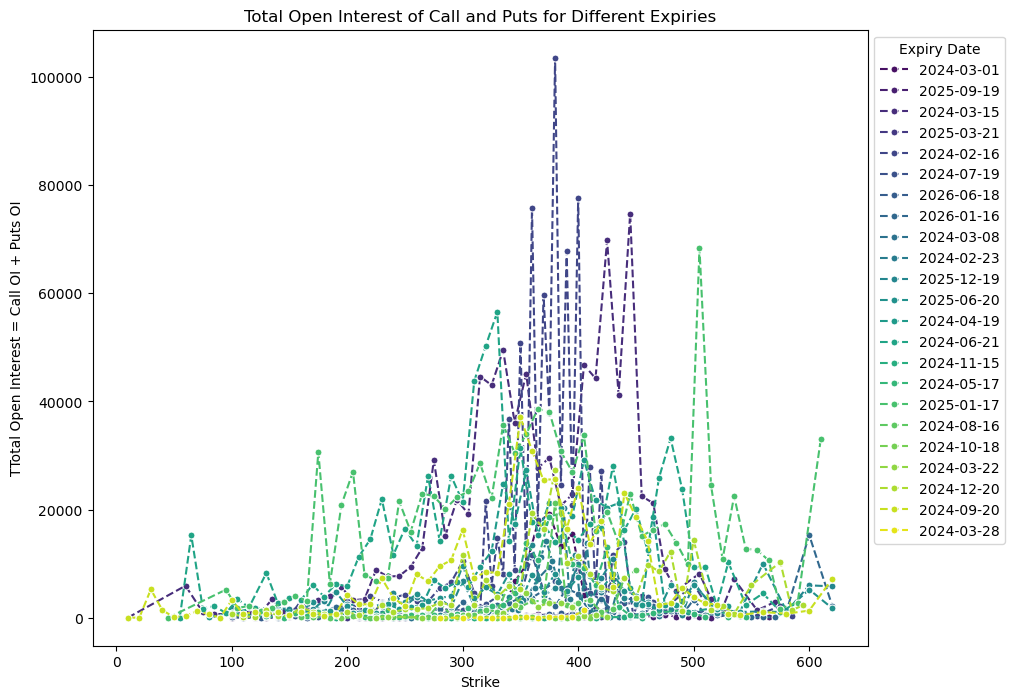

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a reversed color palette for better distinguishability
palette_volume = sns.color_palette('viridis', n_colors=len(set(option_call_put_volume['expirationDate'])))

plt.figure(figsize=(10, 8))

for i, expiry_date in enumerate(set(option_call_put_OI['expirationDate'])):
    df_OI = option_call_put_OI[option_call_put_OI['expirationDate'] == expiry_date].copy()
    
    # Plot histogram with markers and different line styles
    sns.lineplot(data=df_OI, x='strike', y='openInterest', label=expiry_date, 
                 color=palette_volume[i], marker='o', linestyle='--', markersize=5)

plt.title('Total Open Interest of Call and Puts for Different Expiries')
plt.xlabel('Strike')
plt.ylabel('TTotal Open Interest = Call OI + Puts OI')
plt.legend(title='Expiry Date', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

###  1.2 : Storing and Filtering Option Chain Data in DataFrame

In this step we perform following steps 
- Change the format of date form object to datetime and use it to get the Expiration date
- Calcaulte the Maturity time left for each contracts
- Filter contracts based on whether they are call type or put type
- Converting object datatype to numeric
- Removing unwanted columns from dataframe

In [35]:
# change the format of date form object to datetime and use it to get the Expiration date
option['expirationDate'] = pd.to_datetime(option['expirationDate']) + datetime.timedelta(days = 1)     
# Calcaulte the Maturity time left for each contracts                
option['Time_to_Expire'] = (option['expirationDate'] - datetime.datetime.today()).dt.days / 365
# Filter contracts based on whether they are call type or put type
option['CALL'] = option['contractSymbol'].str[4:].apply(lambda x: "C" in x)
#Converting object datatype to numeric
option[['bid', 'ask', 'strike']] = option[['bid', 'ask', 'strike']].apply(pd.to_numeric)
#Removing unwanted columns from dataframe
option = option.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
option

,contractSymbol,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,Time_to_Expire,CALL
0,AAPL240216C00050000,50.0,136.95,137.10,2.0,2.0,4.531254,True,2024-02-17,0.008219,True
1,AAPL240216C00055000,55.0,131.95,132.20,2.0,0.0,4.421879,True,2024-02-17,0.008219,True
2,AAPL240216C00060000,60.0,126.95,127.10,2.0,0.0,3.929688,True,2024-02-17,0.008219,True
3,AAPL240216C00065000,65.0,120.50,121.35,1.0,1.0,0.000010,True,2024-02-17,0.008219,True
4,AAPL240216C00070000,70.0,116.95,117.25,5.0,1.0,3.660157,True,2024-02-17,0.008219,True
...,...,...,...,...,...,...,...,...,...,...,...
1856,AAPL260618P00230000,230.0,43.40,45.65,2.0,7.0,0.122079,True,2026-06-19,2.345205,False
1857,AAPL260618P00235000,235.0,47.60,49.80,129.0,8.0,0.116464,True,2026-06-19,2.345205,False
1858,AAPL260618P00240000,240.0,51.35,55.05,NaN,2.0,0.128396,True,2026-06-19,2.345205,False
1859,AAPL260618P00300000,300.0,110.90,114.70,1.0,0.0,0.194558,True,2026-06-19,2.345205,False


###  1.3 : Downloading Historical Data of Option Contracts and Building storing them as a Dictionary  

In this code we make list of all option contracts symbols and store them in a dictionary, we will be using them for downloading historical data using yfinance library

In [36]:

option_contracts_list={}            # Create dictionary to sote the contract name/symbol
option_contracts_list['Call Contracts Tickers']=option[option['CALL']==True][['contractSymbol','strike','expirationDate']]
option_contracts_list['Put Contracts Tickers']=option[option['CALL']==False][['contractSymbol','strike','expirationDate']]


In this code we will download all the histrorical data of option contracts using yfinance library. We will be using this data for empirically testing the Iron condor PnL and Iron condor with Extra Put PnL

### **DONT RUN THE CELL BELOW**

- Yfinance blocks IP if several requests are made,as a result following code cannot be run more than 2-3 times. 
- So Instead option contracts historical data is stored as dictionary using pickle.
- File is already downloaded so we just need to load it. 
- If code need to be run uncomment and Run

In [37]:
# # Uncomment to Run the Code
# # Creating Dictionary of options Contract hisotrical data
# option_contracts_data={'Call Contracts':{},
#                        'Put Contracts':{}}
# for contracts in option_contracts_list['Call Contracts Tickers']['contractSymbol'].to_list():
#     option_contracts_data['Call Contracts'][contracts] = yf.download(contracts)
# for contracts in option_contracts_list['Put Contracts Tickers']['contractSymbol'].to_list():
#     option_contracts_data['Put Contracts'][contracts]= yf.download(contracts)


In [38]:
import pickle
# # # Uncomment to Save dictionary to option_contracts_data.pkl file
# with open('option_contracts_data.pkl', 'wb') as fp:
#     pickle.dump(option_contracts_data, fp)
#     print('dictionary saved successfully to file')

#Load Dictionary
#File name is store as option_contract_data.pkl
with open('option_contracts_data.pkl', 'rb') as fp:
    option_contracts_data = pickle.load(fp)

In [39]:
option_contracts_data

{'Call Contracts': {'AAPL240216C00050000':                   Open        High         Low       Close   Adj Close  Volume
  Date                                                                          
  2023-10-23  121.000000  121.000000  121.000000  121.000000  121.000000       1
  2023-11-10  136.399994  136.399994  136.399994  136.399994  136.399994       1
  2023-11-27  139.880005  139.880005  139.880005  139.880005  139.880005       1
  2023-11-28  140.470001  140.470001  140.070007  140.070007  140.070007       2
  2023-11-29  139.429993  139.759995  139.429993  139.759995  139.759995       2
  2023-12-20  145.880005  145.880005  145.880005  145.880005  145.880005       6
  2024-01-09  134.149994  135.070007  134.149994  134.600006  134.600006       6
  2024-01-11  134.600006  134.600006  134.600006  134.600006  134.600006      14
  2024-01-17  132.330002  132.330002  132.330002  132.330002  132.330002       2
  2024-01-23  144.940002  145.149994  144.940002  145.149994  145.14

In [40]:
expirations_dates_list=[
 '2024-02-16',
 '2024-02-23',
 '2024-03-01',
 '2024-03-15',
 '2024-04-19',
 '2024-05-17',
 '2024-06-21',
 '2024-07-19',
 '2024-08-16',
 '2024-09-20',
#  '2024-12-20',  # Data for these expiration dates not available for the strikes used in strategy building.
#  '2025-01-17',  # Data for these expiration dates not available for the strikes used in strategy building.
#  '2025-03-21',  # Data for these expiration dates not available for the strikes used in strategy building.
 '2025-06-20',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18']


# All Option Data is stored in a Dictionary with expiry dates as keys. Using  "2024-02-06" as a key we can see the structure of the Option Chain as a DataFrame.
option_chain_data['2024-02-16'].head() # Filter the option data for the recent strike price 

,contract Call,Price Call,Price Change Call,Price %Change Call,Call Volume,Call OI,Call IV,strike,Price Put,Price Change Put,Price %Change Put,Put Volume,Put OI,Put IV,contract Put
0,AAPL240216C00050000,139.55,0.000000,0.000000,2,2,4.531254,50.0,0.01,0.0,0.0,28.0,251.0,3.375002,AAPL240216P00050000
1,AAPL240216C00055000,133.30,-6.949997,-4.955434,2,0,4.421879,55.0,0.01,0.0,0.0,36.0,137.0,3.187502,AAPL240216P00055000
2,AAPL240216C00060000,128.30,0.500000,0.391236,2,0,3.929688,60.0,0.01,0.0,0.0,1.0,88.0,3.250002,AAPL240216P00060000
3,AAPL240216C00065000,117.06,0.000000,0.000000,1,1,0.000010,65.0,0.01,0.0,0.0,40.0,353.0,3.000002,AAPL240216P00065000
4,AAPL240216C00070000,116.53,0.000000,0.000000,5,1,3.660157,70.0,0.01,0.0,0.0,5.0,580.0,3.078127,AAPL240216P00070000


## STEP 2 : Visualizating Iron Condor and its Variations  using OPTSTRAT Python Library


In this step we see different variation of Iron Condor and how they behave with different Stirkes, Different spread and differnt premiums 

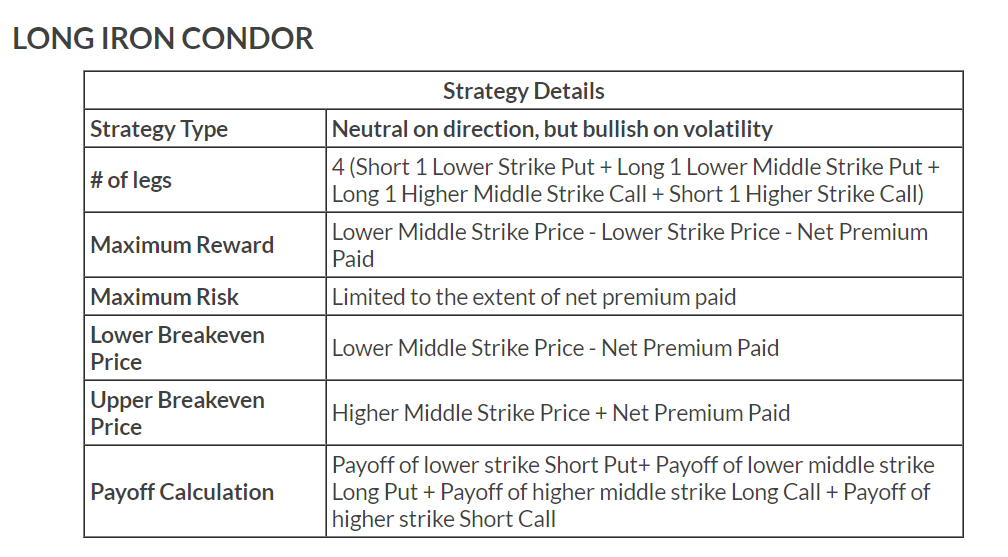

### Building Long Iron Condor (4 leged Strategy):


1. Buy 1 OTM Put (Lower Strike than spot ) 
2. Buy 1 OTM Call (Higer Strike than spot ) 
3. Sell 1 OTM Put (More Lower Strike than spot) 
4. Sell 1 OTM Call (More Higher Strike than spot)

Maximum Profit:  Net Premium Received

Maximum Loss: 
Strike Price of Long Call - Strike Price of Short Call - Net Premium Received or (Strike Price of Short Put - Strike Price of Long Put - Net Premium Received) whichever is higher

Breakeven:
Upper side: Strike Price of Short Call + Net Premium Received Lower side: Strike Price of Short Put - Net Premium Received


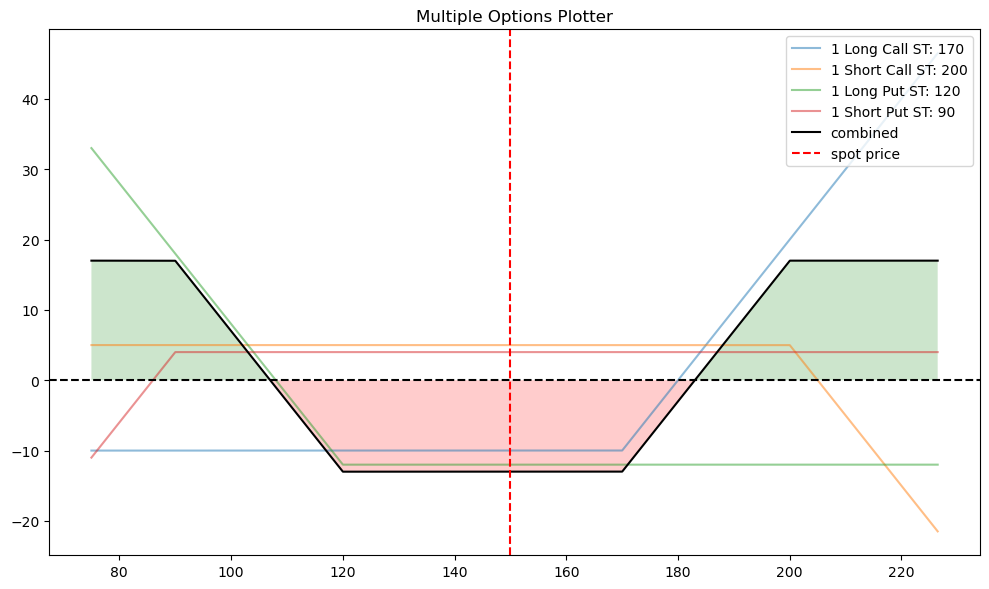

In [41]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 'b', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 's', 'op_pr': 5}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 'b', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 90, 'tr_type': 's', 'op_pr': 4}

op_list=[op1, op2, op3, op4]
op.multi_plotter(spot=150,spot_range=50, op_list=op_list)


### Building Short Iron Condor (4 leged Strategy):




    1. Sell 1 OTM Put (Lower Strike than spot ) 
    2. Sell 1 OTM Call (Higer Strike than spot ) 
    3. Buy 1 OTM Put (More Lower Strike than spot) 
    4. Buy 1 OTM Call (More Higher Strike than spot)

Maximum Profit:  Net Premium Received

Maximum Loss: 
Strike Price of Long Call - Strike Price of Short Call - Net Premium Received or (Strike Price of Short Put - Strike Price of Long Put - Net Premium Received) whichever is higher

Breakeven:
Upper side: Strike Price of Short Call + Net Premium Received Lower side: Strike Price of Short Put - Net Premium Received


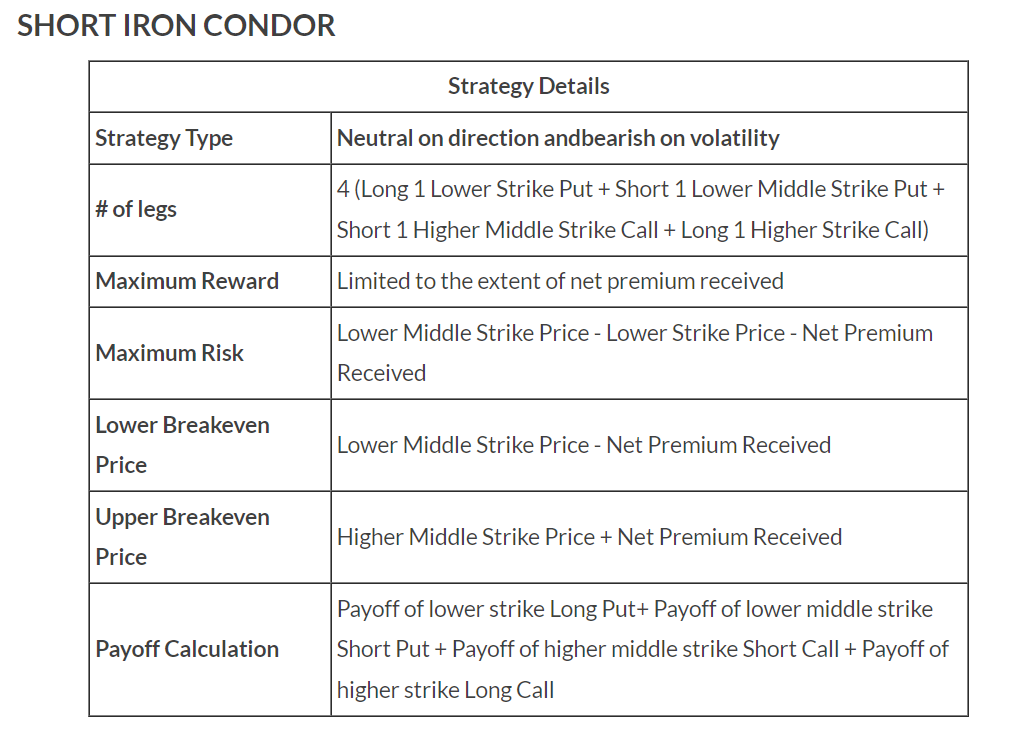

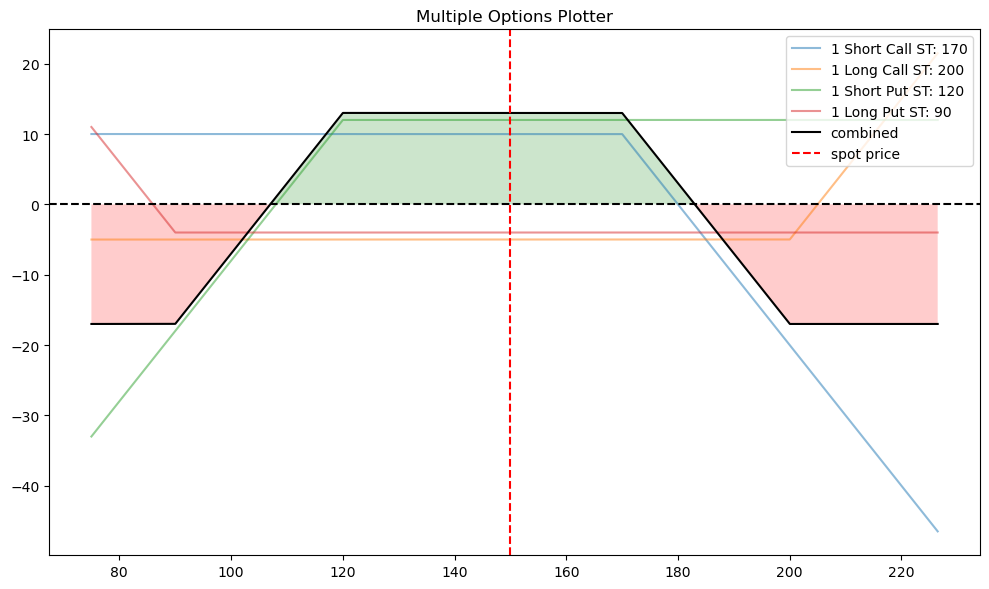

In [42]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 'b', 'op_pr': 5}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 's', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 90, 'tr_type': 'b', 'op_pr': 4}

op_list=[op1, op2, op3, op4]
op.multi_plotter(spot=150,spot_range=50, op_list=op_list)


### Building Asymmetric Iron Condor With Extra Long Put

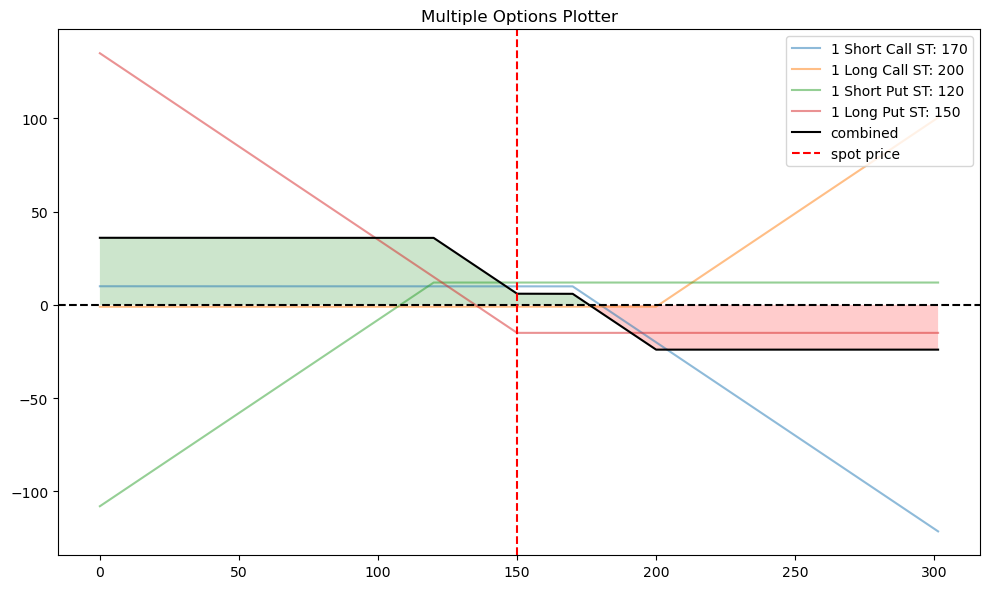

In [43]:
op1={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 10}
op2={'op_type': 'c', 'strike': 200, 'tr_type': 'b', 'op_pr': 1}
op3={'op_type': 'p', 'strike': 120, 'tr_type': 's', 'op_pr': 12}
op4={'op_type': 'p', 'strike': 150,  'tr_type': 'b', 'op_pr': 15}

op_list=[op1, op2, op3, op4]
op.multi_plotter(spot=150,spot_range=100, op_list=op_list)


## Step 3 : Building Strategy to deploy an Iron Condor and its Variation

In [44]:
def get_market_data(tickers=['AAPL'],period='1Y'):
    """
    Used to get the market Data form the yfinance Library

    Paramters are similar to yfinacne API 

    This funtion check the behviour of market and  categories it into 5 forms.

    - Bullish
    - SideWays
    - Bearish

    TO DO 
    - To be extended for multiple tickers , for that the IronCondor Object need to be modified.
    - All More trends - Slightly Bullish/Bearish
    - Plotting the trends along with PnL Plot of Option Strategies

    """
    df=yf.download(tickers=tickers,period=period)
    """
    """ 
    df['sma50']=df['Adj Close'].rolling(window=50).mean()
    df['sma100']=df['Adj Close'].rolling(window=100).mean()
    df['Trend']='SideWays'
    df['Trend'][df['Close']>df['sma50']]='Bullish'
    df['Trend'][df['Close']<df['sma100']]='Bearish'
    # df=df.reset_index()
    # df['Week']=df.index.dt.isocalendar().week
    # df['Month']=df.dt.month
    return df

In [45]:
get_market_data()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,sma50,sma100,Trend
Date,,,,,,,,,
2023-02-13,150.949997,154.259995,150.919998,153.850006,153.033173,62199000,NaN,NaN,SideWays
2023-02-14,152.119995,153.770004,150.860001,153.199997,152.386597,61707600,NaN,NaN,SideWays
2023-02-15,153.110001,155.500000,152.880005,155.330002,154.505295,65573800,NaN,NaN,SideWays
2023-02-16,153.509995,156.330002,153.350006,153.710007,152.893890,68167900,NaN,NaN,SideWays
2023-02-17,152.350006,153.000000,150.850006,152.550003,151.740067,59144100,NaN,NaN,SideWays
...,...,...,...,...,...,...,...,...,...
2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800,190.308160,183.837023,SideWays
2024-02-07,190.639999,191.050003,188.610001,189.410004,189.168625,53439000,190.296975,183.975858,SideWays
2024-02-08,189.389999,189.539993,187.350006,188.320007,188.080017,40962000,190.267613,184.111088,SideWays


#### Option Greeks
- Delta of Options are calculated using Black Schole Equations and saved in the option chain. This will be used for Delta based Iron Condor Strategy. However Due to Black Scholes assumption of constant volatility, Black Scholes formula cannot give accurate predictions.
- These greeks are planned to be used in startegy analysis. [ TO BE DONE LATER]

In [46]:
for expiry_date in expirations_dates_list[1:]:
    rf=0.06
    dte=(datetime.datetime.strptime(expiry_date, "%Y-%m-%d")-datetime.datetime.now()).days
    d1_call = (1 / (option_chain_data[expiry_date]['Call IV'] * (dte ** 0.5))) * (np.log(spot_price / option_chain_data[expiry_date]['strike'])) + (rf + ((option_chain_data[expiry_date]['Call IV'] ** 2) / 2) * dte)
    option_chain_data[expiry_date]['Call Delta'] = norm.cdf(d1_call)
    d1_put = (1 / (option_chain_data[expiry_date]['Put IV'] * (dte ** 0.5))) * (np.log(spot_price / option_chain_data[expiry_date]['strike'])) + (rf + ((option_chain_data[expiry_date]['Put IV'] ** 2) / 2) * dte)
    option_chain_data[expiry_date]['Put Delta'] = 1-norm.cdf(d1_put)
option_chain_data['2024-02-23']

,contract Call,Price Call,Price Change Call,Price %Change Call,Call Volume,Call OI,Call IV,strike,Price Put,Price Change Put,Price %Change Put,Put Volume,Put OI,Put IV,contract Put,Call Delta,Put Delta
0,AAPL240223C00100000,89.33,0.000000,0.000000,NaN,1,1.660158,100.0,0.01,0.00,0.000000,167.0,919,1.062505,AAPL240223P00100000,1.000000,4.741534e-08
1,AAPL240223C00110000,83.50,0.000000,0.000000,NaN,1,1.468753,110.0,0.01,0.00,0.000000,70.0,367,0.921876,AAPL240223P00110000,1.000000,2.290280e-05
2,AAPL240223C00120000,75.00,0.000000,0.000000,1.0,1,1.253910,120.0,0.01,0.00,0.000000,101.0,243,0.781252,AAPL240223P00120000,1.000000,1.369119e-03
3,AAPL240223C00130000,62.10,0.000000,0.000000,1.0,31,1.081059,130.0,0.01,-0.01,-50.000000,40.0,493,0.710940,AAPL240223P00130000,1.000000,6.127267e-03
4,AAPL240223C00135000,53.70,0.000000,0.000000,NaN,3,0.983887,135.0,0.01,0.00,0.000000,10.0,299,0.648441,AAPL240223P00135000,0.999997,1.702762e-02
5,AAPL240223C00140000,50.00,0.000000,0.000000,2.0,3,0.889650,140.0,0.01,-0.01,-50.000000,11.0,314,0.578129,AAPL240223P00140000,0.999904,4.175249e-02
6,AAPL240223C00145000,43.32,0.000000,0.000000,1.0,2,0.826174,145.0,0.02,0.00,0.000000,2.0,317,0.250007,AAPL240223P00145000,0.999390,2.482989e-01
7,AAPL240223C00150000,37.00,0.000000,0.000000,2.0,28,0.716800,150.0,0.02,-0.01,-33.333336,42.0,1542,0.486333,AAPL240223P00150000,0.993328,1.011264e-01
8,AAPL240223C00155000,34.50,0.000000,0.000000,1.0,22,0.657230,155.0,0.03,-0.01,-25.000000,7.0,774,0.421881,AAPL240223P00155000,0.982081,1.565165e-01
9,AAPL240223C00157500,31.27,0.000000,0.000000,NaN,10,0.605473,157.5,0.04,0.00,0.000000,NaN,331,0.402350,AAPL240223P00157500,0.964382,1.760916e-01


Iron Condor Strategy used for all cases of Symmetric and Asymmteric IC 
- ATM is selected from the option chain
- For Selling, 3 Strikes Above/Below OTMS are taken
- For Buying 6 Strikes above/below Deep OTMS are taken
- Net Premium are calculated for the past dates, the data is available.
- PnL is caluclated for the present Day.


In [47]:
class IronCondor:
    """
    Iron Condor object is created
    """
    def __init__(self,option_chain,spot_price,option_contracts_data,expiry_date):
        """
        Initiates an Iron codor based on 
        1. option chain data for a an expiry - > This is a snapshot of EOD Option Data for an expiry date
        2. Market data -> Holds Market Data
        3. Option_contract_data - > Holds historical Data of All options of a given stock
        4. expiry_date - > Expiry date of contract

        """
        self.expiry_date=expiry_date
        self.option_chain_data=option_chain[expiry_date]
        self.spot_price=spot_price
        self.option_contracts_data=option_contracts_data
        self.asset=get_market_data()[['Close','Trend']]
        self.dte=(datetime.datetime.strptime(expiry_date, "%Y-%m-%d")-datetime.datetime.now()).days
        
    def select_strikes(self):
        """
        This method selects Options Strikes for building Iron Condor
        Select 3 strikes OTM for selling
        Select 6 strike for OTM buying
        """

        self.ATM_Strike=min(self.option_chain_data['strike'].values, key=lambda x: abs(x - self.spot_price))
        self.ATM_index=pd.Index(self.option_chain_data['strike'].values).get_loc(self.ATM_Strike)
        self.short_put_strike = self.option_chain_data.loc[self.ATM_index-3, 'strike']
        self.short_call_strike = self.option_chain_data.loc[self.ATM_index+3, 'strike']
        self.long_call_strike = self.option_chain_data.loc[self.ATM_index+6, 'strike']
        self.long_put_strike = self.option_chain_data.loc[self.ATM_index-6, 'strike']

        self.short_put_contracts = self.option_chain_data.loc[self.ATM_index-3, 'contract Put']
        self.short_call_contracts = self.option_chain_data.loc[self.ATM_index+3, 'contract Call']
        self.long_call_contracts = self.option_chain_data.loc[self.ATM_index+6, 'contract Call']
        self.long_put_contracts = self.option_chain_data.loc[self.ATM_index-6, 'contract Put']

    def premiums_data(self):
        """
        This method builds the PnL trajectory of Iron Condor Strategy  
        """
        self.short_put_premium_history = self.option_contracts_data['Put Contracts'][self.short_put_contracts]['Close']
        self.short_call_premium_history = self.option_contracts_data['Call Contracts'][self.short_call_contracts]['Close']
        self.long_call_premium_history = self.option_contracts_data['Call Contracts'][self.long_call_contracts]['Close']
        self.long_put_premium_history = self.option_contracts_data['Put Contracts'][self.long_put_contracts]['Close']

        self.premium_data_history = pd.DataFrame({"short_put":self.short_put_premium_history,
                                   "short_call":self.short_call_premium_history,
                                   "long_call":self.long_call_premium_history,
                                   "long_put":self.long_put_premium_history})
        self.premium_data_history['Iron Condor Price']=self.premium_data_history['short_put']+self.premium_data_history['short_call']-self.premium_data_history['long_call']-self.premium_data_history['long_put']
        self.premium_data_history['Profit']=self.premium_data_history['Iron Condor Price'].diff().cumsum()*-1
        self.premium_data_history=pd.merge(self.premium_data_history, self.asset, left_index=True, right_index=True, how='inner')
        self.premium_data_history['premium_change']=self.premium_data_history['Iron Condor Price'].diff()
        

    def plot(self):
        """
        This method plot the rolling mean of PnL of Iron Condor 
        """
        label=str(f'Days to Expiry {self.dte} Days')
        self.premium_data_history['Profit'].rolling(window=7).mean().plot(figsize=(10,9),label=label)
        plt.ylabel("Profit and Loss in $")
        plt.title("Profit and Loss for Symmetric Iron Condor for Different Maturities")
        plt.legend(fontsize='small',loc='center left', bbox_to_anchor=(1, 0.5))



    def statistics(self):
        
        """
        This method checks the mean and variance of Iron Strategy deployed on different Expiries.
        """
        self.mean=self.premium_data_history.groupby('Trend')['premium_change'].mean()
        self.std=self.premium_data_history.groupby('Trend')['premium_change'].std()
        self.statistics_df=pd.DataFrame([self.mean,self.std],index=[['DTE ' + str(self.dte),'DTE ' + str(self.dte)],['Mean','Variance']])
        return self.statistics_df
    
    def performance(self):
        """
        This method gives overall PnL of Iron Condor Strategy for a given Expiry
        """
        first_non_nan_value = next((value for value in self.premium_data_history['Iron Condor Price'] if not np.isnan(value)), None)
        last_value = self.premium_data_history['Iron Condor Price'][-1]
        self.pnl = first_non_nan_value - last_value if first_non_nan_value is not None else None
        first_non_nan_index = next((i for i, value in enumerate(self.premium_data_history['Iron Condor Price']) if not np.isnan(value)), None)
        self.days_backtested = len(self.premium_data_history['Iron Condor Price']) - first_non_nan_index if first_non_nan_index is not None else None
        self.performance_df = pd.DataFrame({'Backtested Days': [self.days_backtested],
                                            'PnL': [self.pnl]},
                                        index=['DTE ' + str(self.dte)])
        return self.performance_df





[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


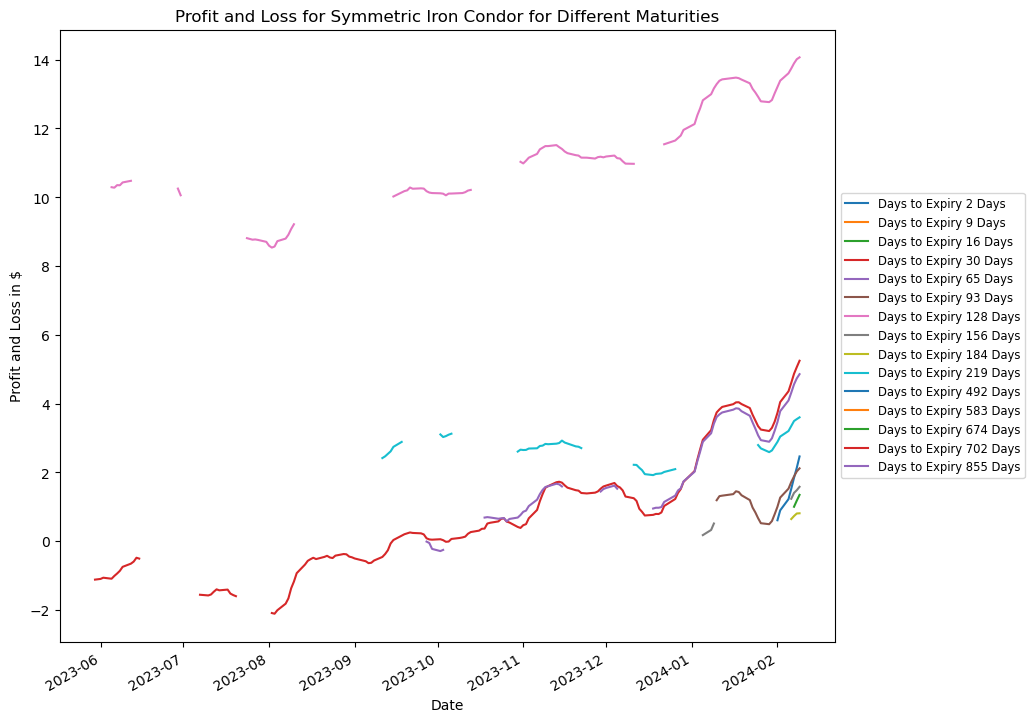

In [48]:
# Compilation of Performance Parameters of Symmetric Short Iron Condor  
Long_condor_statistics=pd.DataFrame()
Long_condor_performance=pd.DataFrame()
for expiry_date in expirations_dates_list:
    Iron_condor=IronCondor(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date)
    Iron_condor.select_strikes()
    Iron_condor.premiums_data()
    Iron_condor.plot()
    Long_condor_statistics=pd.concat([Long_condor_statistics,Iron_condor.statistics()])
    Long_condor_performance=pd.concat([Long_condor_performance,Iron_condor.performance()])



In [49]:
Long_condor_statistics

Trend              Bearish   Bullish  SideWays
DTE 2   Mean           NaN -0.140000 -0.280000
        Variance       NaN  0.168721  0.348676
DTE 9   Mean           NaN       NaN       NaN
        Variance       NaN       NaN       NaN
DTE 16  Mean           NaN -0.023333 -0.143636
        Variance       NaN  0.261024  0.300176
DTE 30  Mean     -0.045686  0.008900 -0.119250
        Variance  0.299301  0.325747  0.544687
DTE 65  Mean     -0.052750  0.007857 -0.161905
        Variance  0.417483  0.377356  0.353746
DTE 93  Mean      0.020000  0.028571 -0.134211
        Variance  0.042427  0.349639  0.328537
DTE 128 Mean     -0.049348  0.000889 -0.160882
        Variance  0.337253  0.411390  0.342127
DTE 156 Mean     -0.225000  0.052500 -0.111765
        Variance  0.091924  0.394003  0.323945
DTE 184 Mean           NaN -0.063334 -0.075555
        Variance       NaN  0.409186  0.275005
DTE 219 Mean     -0.008919 -0.017174 -0.125909
        Variance  0.331066  0.291316  0.364164
DTE 492 Mean     -0.142857  0.125000  0.337143
        Variance  0.861272  0.546468  0.900623
DTE 583 Mean           NaN       NaN       NaN
        Variance       NaN       NaN       NaN
DTE 674 Mean     -0.005999 -0.036842  0.565000
        Variance  0.810874  0.947981  1.308149
DTE 702 Mean     -0.147999  0.092857 -0.250000
        Variance  0.557377  1.020388  0.871435
DTE 855 Mean           NaN       NaN -0.980000
        Variance       NaN       NaN       NaN

In [50]:
Long_condor_performance

,Backtested Days,PnL
DTE 2,14,3.080000
DTE 9,1,0.000000
DTE 16,19,1.350000
DTE 30,224,7.280000
DTE 65,120,4.910000
DTE 93,32,2.620000
DTE 128,250,5.629999
DTE 156,52,1.520000
DTE 184,24,0.429999
DTE 219,228,3.629998


In [51]:
class AsymmetricIronCondor:
    """
    An Asymmteric Iron Condor object is created
    
    """

    def __init__(self,option_chain,spot_price,option_contracts_data,expiry_date):
        """
        Initiates an Iron codor based on  
        1. option chain data for a an expiry - > This is a snapshot of EOD Option Data for an expiry date
        2. Market data -> Holds Market Data
        3. Option_contract_data - > Holds historical Data of All options of a given stock
        4. expiry_date - > Expiry date of contract

        """
        self.expiry_date=expiry_date
        self.option_chain_data=option_chain[expiry_date]
        self.spot_price=spot_price
        self.option_contracts_data=option_contracts_data
        self.asset=get_market_data()[['Close','Trend']]
        self.dte=(datetime.datetime.strptime(expiry_date, "%Y-%m-%d")-datetime.datetime.now()).days

        
    def select_strikes(self):
        """
        This method selects Options Strikes for building Iron Condor
        Select 3 strikes OTM for selling
        Select 6 strike for OTM buying

        """
        self.ATM_Strike=min(self.option_chain_data['strike'].values, key=lambda x: abs(x - self.spot_price))
        self.ATM_index=pd.Index(self.option_chain_data['strike'].values).get_loc(self.ATM_Strike)
        self.short_put_strike = self.option_chain_data.loc[self.ATM_index-3, 'strike']
        self.short_call_strike = self.option_chain_data.loc[self.ATM_index+3, 'strike']
        self.long_call_strike = self.option_chain_data.loc[self.ATM_index+6, 'strike']
        self.long_put_strike = self.option_chain_data.loc[self.ATM_index-10, 'strike']

        self.short_put_contracts = self.option_chain_data.loc[self.ATM_index-3, 'contract Put']
        self.short_call_contracts = self.option_chain_data.loc[self.ATM_index+3, 'contract Call']
        self.long_call_contracts = self.option_chain_data.loc[self.ATM_index+6, 'contract Call']
        self.long_put_contracts = self.option_chain_data.loc[self.ATM_index-10, 'contract Put']

    def premiums_data(self):
        """
        This method builds the PnL trajectory of Iron Condor Strategy  
        """
        self.short_put_premium_history = self.option_contracts_data['Put Contracts'][self.short_put_contracts]['Close']
        self.short_call_premium_history = self.option_contracts_data['Call Contracts'][self.short_call_contracts]['Close']
        self.long_call_premium_history = self.option_contracts_data['Call Contracts'][self.long_call_contracts]['Close']
        self.long_put_premium_history = self.option_contracts_data['Put Contracts'][self.long_put_contracts]['Close']

        self.premium_data_history = pd.DataFrame({"short_put":self.short_put_premium_history,
                                   "short_call":self.short_call_premium_history,
                                   "long_call":self.long_call_premium_history,
                                   "long_put":self.long_put_premium_history})
        self.premium_data_history['Iron Condor Price']=self.premium_data_history['short_put']+self.premium_data_history['short_call']-self.premium_data_history['long_call']-self.premium_data_history['long_put']
        self.premium_data_history['Profit']=self.premium_data_history['Iron Condor Price'].diff().cumsum()*-1
        self.premium_data_history=pd.merge(self.premium_data_history, self.asset, left_index=True, right_index=True, how='inner')
        self.premium_data_history['premium_change']=self.premium_data_history['Iron Condor Price'].diff()


    def plot(self):
        """
        This method plot the rolling mean of PnL of Iron Condor 
        """
        label=str(f'Days to Expiry {self.dte} Days')
        self.premium_data_history['Profit'].rolling(window=7).mean().plot(figsize=(10,9),label=label)
        plt.ylabel("Profit and Loss in $")
        plt.title("Profit and Loss for Asymmetric Iron Condor for Different Maturities")
        plt.legend(fontsize='small',loc='center left', bbox_to_anchor=(1, 0.5))

    def statistics(self):
        """
        This method checks the mean and variance of Iron Strategy deployed on different Expiries.
        """
        self.mean=self.premium_data_history.groupby('Trend')['premium_change'].mean()
        self.std=self.premium_data_history.groupby('Trend')['premium_change'].std()
        self.df=pd.DataFrame([self.mean,self.std],index=[['DTE '+str(self.dte),'DTE '+str(self.dte)],['Mean','Variance']])
        return self.df

    def performance(self):
        """
        This method gives overall PnL of Iron Condor Strategy for a given Expiry
        """
        first_non_nan_value = next((value for value in self.premium_data_history['Iron Condor Price'] if not np.isnan(value)), None)
        last_value = self.premium_data_history['Iron Condor Price'][-1]
        self.pnl = first_non_nan_value - last_value if first_non_nan_value is not None else None
        first_non_nan_index = next((i for i, value in enumerate(self.premium_data_history['Iron Condor Price']) if not np.isnan(value)), None)
        self.days_backtested = len(self.premium_data_history['Iron Condor Price']) - first_non_nan_index if first_non_nan_index is not None else None
        self.performance_df = pd.DataFrame({'Backtested Days': [self.days_backtested],
                                            'PnL': [self.pnl]},
                                        index=['DTE ' + str(self.dte)])
        return self.performance_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


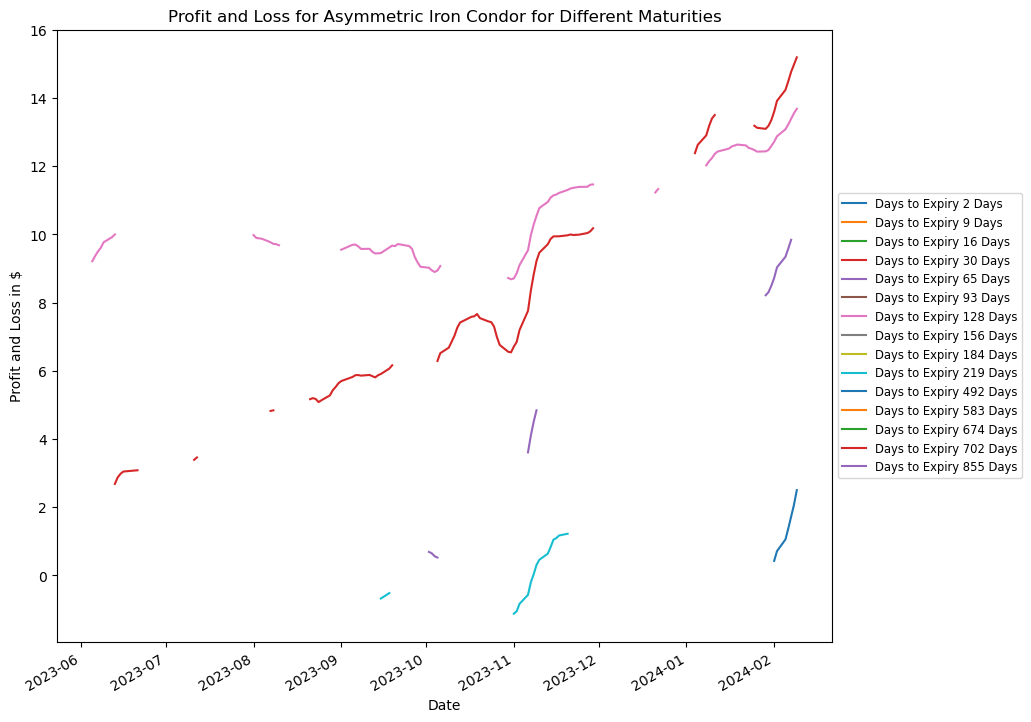

In [52]:
# Compilation of Performance Parameters of Asymmetric Short Iron Condor  
Asymmetric_Iron_Condor_statistics=pd.DataFrame()
Asymmetric_Iron_Condor_performance=pd.DataFrame()
for expiry_date in expirations_dates_list:
    Asymmetric_Iron_Condor=AsymmetricIronCondor(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date)
    Asymmetric_Iron_Condor.select_strikes()
    Asymmetric_Iron_Condor.premiums_data()
    Asymmetric_Iron_Condor.plot()
    Asymmetric_Iron_Condor_statistics=pd.concat([Asymmetric_Iron_Condor_statistics,Asymmetric_Iron_Condor.statistics()])
    Asymmetric_Iron_Condor_performance=pd.concat([Asymmetric_Iron_Condor_performance,Asymmetric_Iron_Condor.performance()])


In [53]:
Asymmetric_Iron_Condor_statistics

Trend              Bearish   Bullish  SideWays
DTE 2   Mean           NaN -0.125000 -0.301111
        Variance       NaN  0.179165  0.508342
DTE 9   Mean           NaN       NaN       NaN
        Variance       NaN       NaN       NaN
DTE 16  Mean           NaN  0.025000 -0.086667
        Variance       NaN  0.374767  0.237290
DTE 30  Mean     -0.065319 -0.079500 -0.159063
        Variance  0.476408  0.326034  0.319186
DTE 65  Mean     -0.103871 -0.154000 -0.290000
        Variance  0.511760  0.285001  0.263643
DTE 93  Mean           NaN -0.056666 -0.182727
        Variance       NaN  0.276466  0.235291
DTE 128 Mean     -0.014762 -0.036023 -0.215750
        Variance  0.412519  0.390533  0.512840
DTE 156 Mean      0.040000  0.083750 -0.192500
        Variance  0.197990  0.201561  0.226952
DTE 184 Mean           NaN  0.083333 -0.160000
        Variance       NaN  0.150443  0.302765
DTE 219 Mean      0.023333 -0.048235 -0.090588
        Variance  0.468172  0.251980  0.393437
DTE 492 Mean     -0.480000 -0.053334  0.223333
        Variance  0.183847  0.421126  0.383753
DTE 583 Mean           NaN       NaN       NaN
        Variance       NaN       NaN       NaN
DTE 674 Mean     -0.303333 -0.032941  0.224999
        Variance  0.785897  0.590718  0.756604
DTE 702 Mean      0.414999 -0.108888 -0.373333
        Variance  0.914860  0.374381  0.579511
DTE 855 Mean           NaN       NaN       NaN
        Variance       NaN       NaN       NaN

In [54]:
Asymmetric_Iron_Condor_performance

,Backtested Days,PnL
DTE 2,14,3.210000
DTE 9,1,0.000000
DTE 16,19,1.650000
DTE 30,224,13.830000
DTE 65,120,7.720000
DTE 93,29,2.650000
DTE 128,250,12.179999
DTE 156,56,2.680000
DTE 184,18,1.239999
DTE 219,227,9.929998


In [55]:
class IronCondorwExtraPutLeg:
    def __init__(self,option_chain,spot_price,option_contracts_data,expiry_date):
        self.expiry_date=expiry_date
        self.option_chain_data=option_chain[expiry_date]
        self.spot_price=spot_price
        self.option_contracts_data=option_contracts_data
        self.asset=get_market_data()[['Close','Trend']]
        self.dte=(datetime.datetime.strptime(expiry_date, "%Y-%m-%d")-datetime.datetime.now()).days

        
    def select_strikes(self):
        #select 3 strikes OTM for selling
        #select 6 strike for OTM buying
        self.ATM_Strike=min(self.option_chain_data['strike'].values, key=lambda x: abs(x - self.spot_price))
        self.ATM_index=pd.Index(self.option_chain_data['strike'].values).get_loc(self.ATM_Strike)
        self.short_put_strike = self.option_chain_data.loc[self.ATM_index-3, 'strike']
        self.short_call_strike = self.option_chain_data.loc[self.ATM_index+3, 'strike']
        self.long_call_strike = self.option_chain_data.loc[self.ATM_index+6, 'strike']
        self.long_put_strike = self.option_chain_data.loc[self.ATM_index-6, 'strike']
        self.extra_long_put_strike = self.option_chain_data.loc[self.ATM_index-8, 'strike']


        self.short_put_contracts = self.option_chain_data.loc[self.ATM_index-3, 'contract Put']
        self.short_call_contracts = self.option_chain_data.loc[self.ATM_index+3, 'contract Call']
        self.long_call_contracts = self.option_chain_data.loc[self.ATM_index+6, 'contract Call']
        self.long_put_contracts = self.option_chain_data.loc[self.ATM_index-6, 'contract Put']
        self.extra_long_put_strike = self.option_chain_data.loc[self.ATM_index-8, 'contract Put']

        

    def premiums_data(self):
        self.short_put_premium_history = self.option_contracts_data['Put Contracts'][self.short_put_contracts]['Close']
        self.short_call_premium_history = self.option_contracts_data['Call Contracts'][self.short_call_contracts]['Close']
        self.long_call_premium_history = self.option_contracts_data['Call Contracts'][self.long_call_contracts]['Close']
        self.long_put_premium_history = self.option_contracts_data['Put Contracts'][self.long_put_contracts]['Close']
        self.extra_long_put_premium_history = self.option_contracts_data['Put Contracts'][self.long_put_contracts]['Close']

        self.premium_data_history = pd.DataFrame({"short_put":self.short_put_premium_history,
                                   "short_call":self.short_call_premium_history,
                                   "long_call":self.long_call_premium_history,
                                   "long_put":self.long_put_premium_history,
                                   "extra_long_put":self.extra_long_put_premium_history})
        self.premium_data_history['Iron Condor Price']=self.premium_data_history['short_put']+self.premium_data_history['short_call']-self.premium_data_history['long_call']-self.premium_data_history['long_put']-self.premium_data_history['extra_long_put']
        self.premium_data_history['Profit']=self.premium_data_history['Iron Condor Price'].diff().cumsum()*-1
        self.premium_data_history=pd.merge(self.premium_data_history, self.asset, left_index=True, right_index=True, how='inner')
        self.premium_data_history['premium_change']=self.premium_data_history['Iron Condor Price'].diff()


    def plot(self):
        """
        This method plot the rolling mean of PnL of Iron Condor 
        """
        label=str(f'Days to Expiry {self.dte} Days')
        self.premium_data_history['Profit'].rolling(window=7).mean().plot(figsize=(10,9),label=label)
        plt.ylabel("Profit and Loss in $")
        plt.title("Profit and Loss for Symmetric Iron Condor for Different Maturities")
        plt.legend(fontsize='small',loc='center left', bbox_to_anchor=(1, 0.5))
        
    def statistics(self):
        self.mean_premium_change=self.premium_data_history.groupby('Trend')['premium_change'].mean()
        self.std_premium_change=self.premium_data_history.groupby('Trend')['premium_change'].std()
        self.df=pd.DataFrame([self.mean_premium_change,self.std_premium_change],index=[['DTE '+str(self.dte),'DTE '+str(self.dte)],['Mean','Variance']])
        return self.df


    def performance(self):
        """
        This method gives overall PnL of Iron Condor Strategy for a given Expiry
        """
        first_non_nan_value = next((value for value in self.premium_data_history['Iron Condor Price'] if not np.isnan(value)), None)
        last_value = self.premium_data_history['Iron Condor Price'][-1]
        self.pnl = first_non_nan_value - last_value if first_non_nan_value is not None else None
        first_non_nan_index = next((i for i, value in enumerate(self.premium_data_history['Iron Condor Price']) if not np.isnan(value)), None)
        self.days_backtested = len(self.premium_data_history['Iron Condor Price']) - first_non_nan_index if first_non_nan_index is not None else None
        self.performance_df = pd.DataFrame({'Backtested Days': [self.days_backtested],
                                            'PnL': [self.pnl]},
                                        index=['DTE ' + str(self.dte)])
        return self.performance_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


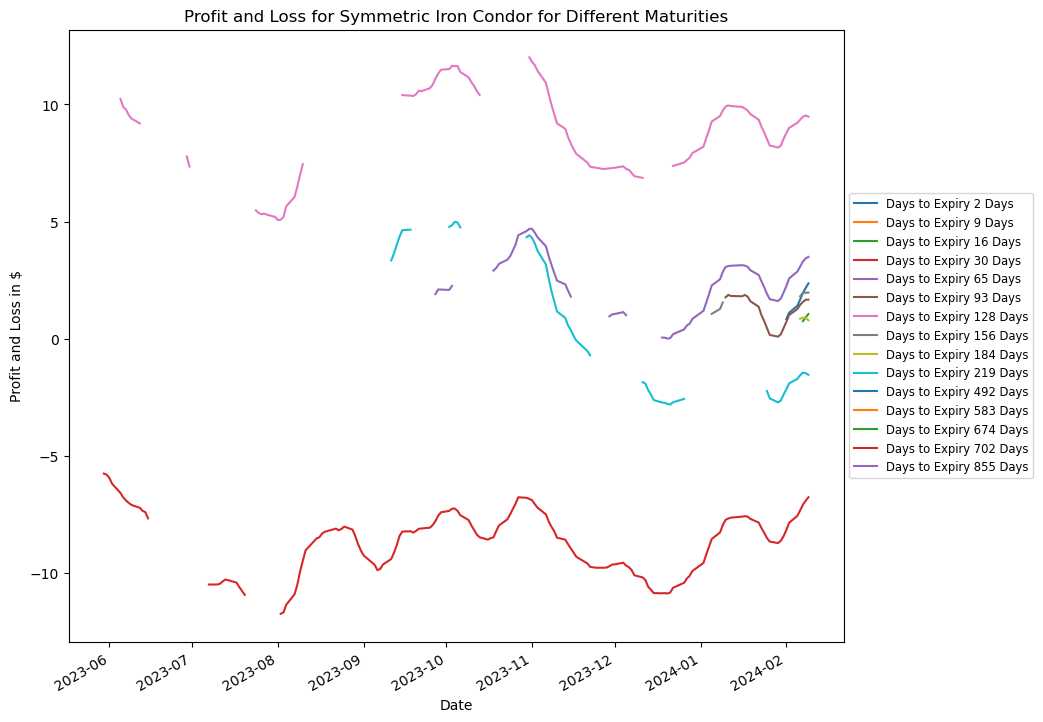

In [56]:
# Compilation of Performance Parameters of Long Iron Condor with Extra Long Put  
Long_condor_with_Extra_long_put_statistics=pd.DataFrame()
Long_condor_with_Extra_long_put_performance=pd.DataFrame()
for expiry_date in expirations_dates_list:
    Iron_Condor_with_Extra_Put_Leg=IronCondorwExtraPutLeg(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date)
    Iron_Condor_with_Extra_Put_Leg.select_strikes()
    Iron_Condor_with_Extra_Put_Leg.premiums_data()
    Iron_Condor_with_Extra_Put_Leg.plot()
    Long_condor_with_Extra_long_put_statistics=pd.concat([Long_condor_with_Extra_long_put_statistics,Iron_Condor_with_Extra_Put_Leg.statistics()])
    Long_condor_with_Extra_long_put_performance=pd.concat([Long_condor_with_Extra_long_put_performance,Iron_Condor_with_Extra_Put_Leg.performance()])


In [57]:
pd.concat([Long_condor_statistics,Asymmetric_Iron_Condor_statistics,],axis=1,keys=['Symmetric Iron Condor','Asymmetric Iron Condor']).dropna()

Symmetric Iron Condor                      \
Trend                          Bearish   Bullish  SideWays   
DTE 30  Mean                 -0.045686  0.008900 -0.119250   
        Variance              0.299301  0.325747  0.544687   
DTE 65  Mean                 -0.052750  0.007857 -0.161905   
        Variance              0.417483  0.377356  0.353746   
DTE 128 Mean                 -0.049348  0.000889 -0.160882   
        Variance              0.337253  0.411390  0.342127   
DTE 156 Mean                 -0.225000  0.052500 -0.111765   
        Variance              0.091924  0.394003  0.323945   
DTE 219 Mean                 -0.008919 -0.017174 -0.125909   
        Variance              0.331066  0.291316  0.364164   
DTE 492 Mean                 -0.142857  0.125000  0.337143   
        Variance              0.861272  0.546468  0.900623   
DTE 674 Mean                 -0.005999 -0.036842  0.565000   
        Variance              0.810874  0.947981  1.308149   
DTE 702 Mean                 -0.147999  0.092857 -0.250000   
        Variance              0.557377  1.020388  0.871435   

                 Asymmetric Iron Condor                      
Trend                           Bearish   Bullish  SideWays  
DTE 30  Mean                  -0.065319 -0.079500 -0.159063  
        Variance               0.476408  0.326034  0.319186  
DTE 65  Mean                  -0.103871 -0.154000 -0.290000  
        Variance               0.511760  0.285001  0.263643  
DTE 128 Mean                  -0.014762 -0.036023 -0.215750  
        Variance               0.412519  0.390533  0.512840  
DTE 156 Mean                   0.040000  0.083750 -0.192500  
        Variance               0.197990  0.201561  0.226952  
DTE 219 Mean                   0.023333 -0.048235 -0.090588  
        Variance               0.468172  0.251980  0.393437  
DTE 492 Mean                  -0.480000 -0.053334  0.223333  
        Variance               0.183847  0.421126  0.383753  
DTE 674 Mean                  -0.303333 -0.032941  0.224999  
        Variance               0.785897  0.590718  0.756604  
DTE 702 Mean                   0.414999 -0.108888 -0.373333  
        Variance               0.914860  0.374381  0.579511

In [58]:
performance=pd.concat([Long_condor_performance,Asymmetric_Iron_Condor_performance],axis=1,keys=['Symmetric Iron Condor','Asymmetric Iron Condor'])
performance

Symmetric Iron Condor           Asymmetric Iron Condor           
              Backtested Days       PnL        Backtested Days        PnL
DTE 2                      14  3.080000                     14   3.210000
DTE 9                       1  0.000000                      1   0.000000
DTE 16                     19  1.350000                     19   1.650000
DTE 30                    224  7.280000                    224  13.830000
DTE 65                    120  4.910000                    120   7.720000
DTE 93                     32  2.620000                     29   2.650000
DTE 128                   250  5.629999                    250  12.179999
DTE 156                    52  1.520000                     56   2.680000
DTE 184                    24  0.429999                     18   1.239999
DTE 219                   228  3.629998                    227   9.929998
DTE 492                   193       NaN                    193   3.230000
DTE 583                    52       NaN                     26        NaN
DTE 674                   228       NaN                    228        NaN
DTE 702                    94       NaN                     99   1.109999
DTE 855                    19       NaN                     19        NaN

In [59]:
# Without NaNs . This is prmarly due to lack of Data
pd.concat([Long_condor_performance,Asymmetric_Iron_Condor_performance,],axis=1,keys=['Symmetric Iron Condor','Asymmetric Iron Condor']).dropna()


Symmetric Iron Condor           Asymmetric Iron Condor           
              Backtested Days       PnL        Backtested Days        PnL
DTE 2                      14  3.080000                     14   3.210000
DTE 9                       1  0.000000                      1   0.000000
DTE 16                     19  1.350000                     19   1.650000
DTE 30                    224  7.280000                    224  13.830000
DTE 65                    120  4.910000                    120   7.720000
DTE 93                     32  2.620000                     29   2.650000
DTE 128                   250  5.629999                    250  12.179999
DTE 156                    52  1.520000                     56   2.680000
DTE 184                    24  0.429999                     18   1.239999
DTE 219                   228  3.629998                    227   9.929998

# STEP 4 : Rebuilding  Iron Condor Class 
In this Step, we will Rebuild the Iron Condor Class for Checking the Performance of Iron Condor for Various Combinations of 
- In the Money Strike (ITM strike) 
- Date to Expiry (DTE)
- Lot size of Asymmetric Condor

In this Step only 4 legs are considered.

In [60]:
class IronCondorStartegy:
    """
    Iron Condor Strategy object is created 

    Initiates an Iron codor based on 

        1. option chain data for a an expiry : This is a snapshot of EOD Option Data for an expiry date\

        2. Market data : Holds Market Data

        3. option_contract_data : Holds historical Data of All options of a given stock

        4. expiry_date : Expiry date of contract

        5. asymmetric :Balance or Unbalanced Delta 

        6. lot_size : Size of Lot for building Asymmteric Iron Condor

        """
    def __init__(self,option_chain,spot_price,option_contracts_data,expiry_date,asymmetric=False,lot_size=1):
 
        self.expiry_date=expiry_date
        self.option_chain_data=option_chain[expiry_date]
        self.market_data=spot_price
        self.option_contracts_data=option_contracts_data
        self.asset=get_market_data()[['Close','Trend']]
        self.dte=(datetime.datetime.strptime(expiry_date, "%Y-%m-%d")-datetime.datetime.now())
        self.asymmetric = asymmetric
        self.lot_size = lot_size
        self.select_strikes()
        self.premiums_data()
       
    def select_strikes(self):
        """
        This method selects Options Strikes for building Iron Condor
        """
        if self.asymmetric==False:
            self.ITM_Strike=min(self.option_chain_data['strike'].values, key=lambda x: abs(x - spot_price))
            self.ITM_index=pd.Index(self.option_chain_data['strike'].values).get_loc(self.ITM_Strike)
            self.short_put_strike = self.option_chain_data.loc[self.ITM_index-3, 'strike']
            self.short_call_strike = self.option_chain_data.loc[self.ITM_index+3, 'strike']
            self.long_call_strike = self.option_chain_data.loc[self.ITM_index+6, 'strike']
            self.long_put_strike = self.option_chain_data.loc[self.ITM_index-6, 'strike']

            self.short_put_contracts = self.option_chain_data.loc[self.ITM_index-3, 'contract Put']
            self.short_call_contracts = self.option_chain_data.loc[self.ITM_index+3, 'contract Call']
            self.long_call_contracts = self.option_chain_data.loc[self.ITM_index+6, 'contract Call']
            self.long_put_contracts = self.option_chain_data.loc[self.ITM_index-6, 'contract Put']
        
        if self.asymmetric==True:
            self.ITM_Strike=min(self.option_chain_data['strike'].values, key=lambda x: abs(x - spot_price))
            self.ITM_index=pd.Index(self.option_chain_data['strike'].values).get_loc(self.ITM_Strike)
            self.short_put_strike = self.option_chain_data.loc[self.ITM_index-3, 'strike']
            self.short_call_strike = self.option_chain_data.loc[self.ITM_index+3, 'strike']
            self.long_call_strike = self.option_chain_data.loc[self.ITM_index+6, 'strike']
            self.long_put_strike = self.option_chain_data.loc[self.ITM_index-10, 'strike']

            self.short_put_contracts = self.option_chain_data.loc[self.ITM_index-3, 'contract Put']
            self.short_call_contracts = self.option_chain_data.loc[self.ITM_index+3, 'contract Call']
            self.long_call_contracts = self.option_chain_data.loc[self.ITM_index+6, 'contract Call']
            self.long_put_contracts = self.option_chain_data.loc[self.ITM_index-10, 'contract Put']
        

    def premiums_data(self):
        """
        This method builds the PnL trajectory of Iron Condor Strategy  
        """
        self.short_put_premium_history = self.option_contracts_data['Put Contracts'][self.short_put_contracts]['Close']
        self.short_call_premium_history = self.option_contracts_data['Call Contracts'][self.short_call_contracts]['Close']
        self.long_call_premium_history = self.option_contracts_data['Call Contracts'][self.long_call_contracts]['Close']
        self.long_put_premium_history = self.option_contracts_data['Put Contracts'][self.long_put_contracts]['Close']

        self.premium_data_history = pd.DataFrame({"short_put":self.short_put_premium_history,
                                   "short_call":self.short_call_premium_history,
                                   "long_call":self.long_call_premium_history,
                                   "long_put":self.long_put_premium_history})
        self.premium_data_history['Iron Condor Price']=self.premium_data_history['short_put']+self.premium_data_history['short_call']-self.lot_size*self.premium_data_history['long_call']-self.premium_data_history['long_put']
        self.premium_data_history['Profit']=self.premium_data_history['Iron Condor Price'].diff().cumsum()*-1
        self.premium_data_history=pd.merge(self.premium_data_history, self.asset, left_index=True, right_index=True, how='inner')
        self.premium_data_history['premium_change']=self.premium_data_history['Iron Condor Price'].diff()
        

    def plot(self):
        """
        This method plot the rolling mean of PnL of Iron Condor 
        """
        label=str(f'Days to Expiry {self.dte} Days')
        self.premium_data_history['Profit'].rolling(window=7).mean().plot(figsize=(10,9),label=label)
        plt.legend(fontsize='small',loc='center left', bbox_to_anchor=(1, 0.5))


    def statistics(self):
        
        """
        This method checks the mean and variance of Iron Strategy deployed on different Expiries.
        """
        self.mean=self.premium_data_history.groupby('Trend')['premium_change'].mean()
        self.std=self.premium_data_history.groupby('Trend')['premium_change'].std()
        self.statistics_df=pd.DataFrame([self.mean,self.std],index=[['DTE ' + str(self.dte),'DTE ' + str(self.dte)],['Mean','Variance']])
        return self.statistics_df
    
    def performance(self):
        """
        This method gives overall PnL of Iron Condor Strategy for a given Expiry
        """
        first_non_nan_value = next((value for value in self.premium_data_history['Iron Condor Price'] if not np.isnan(value)), None)
        last_value = self.premium_data_history['Iron Condor Price'][-1]
        self.pnl = first_non_nan_value - last_value if first_non_nan_value is not None else None
        first_non_nan_index = next((i for i, value in enumerate(self.premium_data_history['Iron Condor Price']) if not np.isnan(value)), None)
        self.days_backtested = len(self.premium_data_history['Iron Condor Price']) - first_non_nan_index if first_non_nan_index is not None else None
        self.performance_df = pd.DataFrame({'Backtested Days': [self.days_backtested],
                                            'PnL': [self.pnl]},
                                        index=['DTE ' + str(self.dte.days)])
        return self.performance_df





In [61]:
# Compilation of condor variations in a single dataframe
IronCondor_df1=pd.DataFrame()
IronCondor_df2=pd.DataFrame()

for expiry_date in expirations_dates_list:
    symIC=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=False,lot_size=1).performance()
    asymIC_1=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=True,lot_size=1).performance()
    asymIC_2=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=True,lot_size=2).performance()
    asymIC_5=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=True,lot_size=5).performance()
    IronCondor_df1=pd.concat([symIC,asymIC_1,asymIC_2,asymIC_5],axis=1)
    IronCondor_df2=pd.concat([IronCondor_df2,IronCondor_df1])


IronCondor_df2.columns = pd.MultiIndex.from_arrays([
    ['Symmetric_Iron_Condor', 'Symmetric_Iron_Condor', 'Asymmetric_Iron_Condor', 'Asymmetric_Iron_Condor', 'Asymmetric_Iron_Condor_w_Lot_Size_2', 'Asymmetric_Iron_Condor_w_Lot_Size_2', 'Asymmetric_Iron_Condor_w_Lot_Size_5', 'Asymmetric_Iron_Condor_w_Lot_Size_5'], 
    ['Backtested Days', 'PnL', 'Backtested Days', 'PnL', 'Backtested Days', 'PnL', 'Backtested Days', 'PnL']
], names=('Type', 'Performance'))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [62]:
IronCondor_df2

Type        Symmetric_Iron_Condor           Asymmetric_Iron_Condor             \
Performance       Backtested Days       PnL        Backtested Days        PnL   
DTE 2                          14  3.080000                     14   3.210000   
DTE 9                           1  0.000000                      1   0.000000   
DTE 16                         19  1.350000                     19   1.650000   
DTE 30                        224  7.280000                    224  13.830000   
DTE 65                        120  4.910000                    120   7.720000   
DTE 93                         32  2.620000                     29   2.650000   
DTE 128                       250  5.629999                    250  12.179999   
DTE 156                        52  1.520000                     56   2.680000   
DTE 184                        24  0.429999                     18   1.239999   
DTE 219                       228  3.629998                    227   9.929998   
DTE 492                       193       NaN                    193   3.230000   
DTE 583                        52       NaN                     26        NaN   
DTE 674                       228       NaN                    228        NaN   
DTE 702                        94       NaN                     99   1.109999   
DTE 855                        19       NaN                     19        NaN   

Type        Asymmetric_Iron_Condor_w_Lot_Size_2             \
Performance                     Backtested Days        PnL   
DTE 2                                        14   1.430000   
DTE 9                                         1   0.000000   
DTE 16                                       19   1.580000   
DTE 30                                      224  10.950000   
DTE 65                                      120   5.160000   
DTE 93                                       29   0.670000   
DTE 128                                     250   9.139999   
DTE 156                                      56  -1.050000   
DTE 184                                      18   1.779999   
DTE 219                                     227   8.129998   
DTE 492                                     193   0.630000   
DTE 583                                      26        NaN   
DTE 674                                     228        NaN   
DTE 702                                      99   0.159998   
DTE 855                                      19        NaN   

Type        Asymmetric_Iron_Condor_w_Lot_Size_5             
Performance                     Backtested Days        PnL  
DTE 2                                        14  -3.910000  
DTE 9                                         1   0.000000  
DTE 16                                       19   1.370000  
DTE 30                                      224   2.310000  
DTE 65                                      120  -2.520000  
DTE 93                                       29  -5.270000  
DTE 128                                     250   0.019998  
DTE 156                                      56 -12.240001  
DTE 184                                      18   3.399999  
DTE 219                                     227   2.729997  
DTE 492                                     193  -7.170002  
DTE 583                                      26        NaN  
DTE 674                                     228        NaN  
DTE 702                                      99  -2.690004  
DTE 855                                      19        NaN

### Checking How performance varies if the middle point of the Iron Condor is changed to 1 sigma above/below present ATM Strike

In [205]:
# If this cell is run, Go back to the spot_price cell + expiries cell and re-run it

spot_price_list=[get_market_data()['Close'][-1]-get_market_data()['Close'].std()
                 ,spot_price,
                 get_market_data()['Close'][-1]+get_market_data()['Close'].std()]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


##### This Part Generates error due to the Lack of Strike Prices to perform the Strategy Used in all cases. Asymmteric Condor Uses 10 stirkes below ATM for Put, which is not available for all expiries. 

To be Resolved later

In [206]:
for spot_price in spot_price_list:
    # Compilation of condor variations in a single dataframe
    IronCondor_df1=pd.DataFrame()
    IronCondor_df2=pd.DataFrame()

    for expiry_date in expirations_dates_list:
        symIC=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=False,lot_size=1).performance()
        asymIC_1=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=True,lot_size=1).performance()
        asymIC_2=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=True,lot_size=2).performance()
        asymIC_5=IronCondorStartegy(option_chain=option_chain_data,spot_price=spot_price,option_contracts_data=option_contracts_data,expiry_date=expiry_date,asymmetric=True,lot_size=5).performance()
        IronCondor_df1=pd.concat([symIC,asymIC_1,asymIC_2,asymIC_5],axis=1)
        IronCondor_df2=pd.concat([IronCondor_df2,IronCondor_df1])


    IronCondor_df2.columns = pd.MultiIndex.from_arrays([
        ['Symmetric_Iron_Condor', 'Symmetric_Iron_Condor', 'Asymmetric_Iron_Condor', 'Asymmetric_Iron_Condor', 'Asymmetric_Iron_Condor_w_Lot_Size_2', 'Asymmetric_Iron_Condor_w_Lot_Size_2', 'Asymmetric_Iron_Condor_w_Lot_Size_5', 'Asymmetric_Iron_Condor_w_Lot_Size_5'], 
        ['Backtested Days', 'PnL', 'Backtested Days', 'PnL', 'Backtested Days', 'PnL', 'Backtested Days', 'PnL']
    ], names=('Type', 'Performance'))


    IronCondor_df2

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

KeyError: 21